In [5]:
import numpy as np
import pandas as pd
# 구글드라이브 연결
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 3
# 데이터파일 불러오기
df = pd.read_csv('/gdrive/My Drive/3-2_machine_learning/image-10k.csv', header=None)

X = df.iloc[:, 1:].values     # 데이터샘플
y = df.iloc[:, 0].values      # 타겟레이블


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE, stratify=y)

images = ['T-shirt', 'Trouser', 'Sweater', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
print(x_train.shape)

(5000, 784)


In [7]:
import tensorflow as tf
from matplotlib import pyplot as plt

image_generator =tf.keras.preprocessing.image.ImageDataGenerator(shear_range = 0.2,
                                   rotation_range = 30,
                                   horizontal_flip = True)#data augmentation을 통해 overfitting 예방

generator = image_generator.flow(x_train.reshape(5000,28,28,1),y_train ,batch_size=50, shuffle=True)
augment_size = 6

img = []
label =[]

for i in range(100*augment_size):
  a,b=generator.next()
  img.extend(a)
  label.extend(b)

x_augmentation = np.asarray(img).reshape(-1,28*28)
y_augmentation = np.asarray(label)

[ True  True  True  True False False False False False False False False
 False False False False False False False  True False False False  True
  True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False False False False False  True False
 False  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False  T

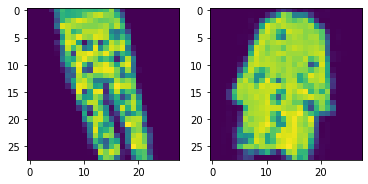

In [8]:
plt.subplot(1,2,1),plt.imshow(x_augmentation[0].reshape(28,28))
plt.subplot(1,2,2),plt.imshow(x_augmentation[5000].reshape(28,28))
plt.show()

In [9]:
import cv2

hog = cv2.HOGDescriptor((28, 28), (14, 14), (7, 7), (7, 7), 9)

hog_x_train = np.zeros((5000*augment_size,324),dtype="float64")
hog_x_test = np.zeros((5000,324),dtype="float64")

for i in range(5000*augment_size):
  hog_x_train[i]=hog.compute(x_augmentation[i].reshape(28,28).astype(np.uint8)).squeeze()

for i in range(5000):
  hog_x_test[i]=hog.compute(x_test[i].reshape(28,28).astype(np.uint8)).squeeze()

x_train = hog_x_train
x_test = hog_x_test
y_train = y_augmentation

In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm


svm_2 = svm.SVC(kernel="rbf",gamma='auto',tol=1e-3,C=5e0,probability=True,random_state=RANDOM_STATE)
svm_3 = svm.SVC(kernel="poly",C=10,probability=True,random_state=RANDOM_STATE)
mlp_1 = MLPClassifier(hidden_layer_sizes=(100,),activation='relu',solver='adam',learning_rate="adaptive",
                      alpha=1e0,batch_size=500, max_iter=500,random_state=RANDOM_STATE)


# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기(기본값은 하드보팅방식)
# 개별 모델을 estimators라는 리스트 인자에다가 (key, value) 튜플 형태로 넣어주기
vo_clf = VotingClassifier(estimators=[('svm_2', svm_2),('svm_3',svm_3),('mlp_1',mlp_1)],  voting='hard')#,('lr',lr)

# Voting분류기 학습
#print(generator.next()[0].shape,generator.next()[1].shape)
vo_clf.fit(*generator.next())
vo_clf.fit(x_train, y_train)
pred_y = vo_clf.predict(x_test)
print('test 정확도', accuracy_score(y_test, pred_y))#Voting 분류기 정확도 0.8628

#Random
#1:0.8594
#2:0.8516
#3:0.8646

ValueError: ignored